# CS Capstone Project — Create IBS SoH Manifest

**Author:** Jason Waterman  
**Course:** UC Berkeley AI/ML Professional Certificate  
**Created:** 2025-10-17  
**Last Updated:** 2025-10-17  
**Version:** 0.1.0  

---

## 📖 Description
This notebook creates an **IBS State of Health (SoH)** manifest from a set of vehicle log files.  
It loads raw IBS network logs, extracts relevant features, computes SoH metrics, and outputs a manifest file for downstream analysis.

The data was gathered over **four distinct phases**:

1. Initial reported IBS SoH
2. When IBS was manually reset via diagnostics
3. Stressing of vehicle battery through various scenarios including
- Forcing the vehicle awake
- Keeping on all headlamps
- Dynamic vehicle driving 
- Driving vehicle sound system to limit 

### 🔑 Objectives
- Parse and clean IBS log data  
- Detect charge/discharge cycles  
- Compute capacity and resistance  
- Generate consolidated SoH manifest -> save to /outputs/logs/manifest.csv

### 💡 Insights




## 1. Setup and imports

In [9]:
# ===== Standard Library =====
import os
import logging
from pathlib import Path
import warnings

# ===== Third-Party Libraries =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.metrics import r2_score, mean_squared_error

# ===== Project Modules =====
# Assuming your capstone repo has a `src/` or `utils/` folder with your modules
from cs_soh_utils import calculate_soh1, detect_cycles_from_voltage, count_cycles_voltage, merge_short_gaps, parse_log_date, compute_log_soh

warnings.filterwarnings("ignore")

## 2. Load data from cleaned data logs and determine IBS SOH and caclculated SOH1

In [10]:
# Build the IBS SOH Log Manifest including calculated SOH1

LOG_DIR = Path("can_data/cleaned")
OUTPUT_MANIFEST_CSV = Path("outputs/logs/manifest.csv")

manifest = []
for csv_path in sorted(LOG_DIR.glob("*.csv")):
    try:
        dfr = pd.read_csv(csv_path, low_memory=False)
    except Exception as e:
        print(f"Skip {csv_path.name}: {e}")
        continue

    log_date = parse_log_date(dfr)
    soh = compute_log_soh(dfr)
    soh1, soh_c, soh_r = calculate_soh1(dfr, return_components=True, return_series=False)

    cycles_count_raw, cycles_windows = count_cycles_voltage(
        dfr,
        time_col="time_utc",              # or "time"
        vol_col="IBS_BatteryVoltage",
        resample="1S",
        median_win_s=3,
        th_on_v=13.4,
        th_off_v=13.2,
        min_len_s=10,
        enforce_min_one=False            # let us recompute after merging
    )

    # Merge brief gaps, then enforce min=1
    merged_windows = merge_short_gaps(cycles_windows, max_gap_s=5)
    cycles_count = max(1, len(merged_windows))

    manifest.append({
        "log_id": csv_path.stem,
        "time": log_date,
        "soh": soh,            # fraction (0..1) preferred
        "soh1": soh1,          # fraction (0..1) preferred
        "soh_c": soh_c,
        "soh_r": soh_r,
        "cycles": cycles_count,
        "path": str(csv_path)
        # optionally store windows if you want later KPIs:
        # "cycle_windows": merged_windows
    })

df_logs = pd.DataFrame(manifest).sort_values("time").reset_index(drop=True)

# If SoH columns are actually in %, normalize to fraction
if df_logs["soh"].max() > 1.5:
    df_logs["soh"] = df_logs["soh"] / 100.0
if df_logs["soh1"].max() > 1.5:
    df_logs["soh1"] = df_logs["soh1"] / 100.0

df_manifest = df_logs.set_index("time")
df_manifest.to_csv(OUTPUT_MANIFEST_CSV, index=True)
df_manifest

,log_id,soh,soh1,soh_c,soh_r,cycles,path
time,,,,,,,
2025-06-26 02:20:47,12V Management 2025-06-25_22-20-47_IBS_only_c...,0.66,0.933828,0.673469,1.000000,3,can_data/cleaned/12V Management 2025-06-25_22...
2025-06-26 17:39:25,12V_Management_2025-06-26_13-39-25_IBS_only,0.66,0.946766,0.671756,0.996595,2,can_data/cleaned/12V_Management_2025-06-26_13-...
2025-06-29 10:07:06,12V Management IBS 1hr Reset 2025-06-29_09-32...,1.00,1.000000,0.997506,1.000000,1,can_data/cleaned/12V Management IBS 1hr Reset...
2025-06-29 12:10:35,12V Management Discharge and Charge Cycle 202...,0.66,0.829054,0.664987,0.993120,2,can_data/cleaned/12V Management Discharge and...
2025-08-10 12:33:02,12V_IBS_Charge_Discharge_after_IBS_Reset_00003...,0.90,0.978152,0.855107,0.984946,6,can_data/cleaned/12V_IBS_Charge_Discharge_afte...
2025-08-16 03:18:17,12V_IBS_Charge_Discharge_after_IBS_00007_IBS_only,0.90,0.938297,0.880196,0.983994,9,can_data/cleaned/12V_IBS_Charge_Discharge_afte...
2025-08-16 12:43:42,12V_IBS_Charge_during_L2_HV_charning_after_IBS...,0.90,0.936143,0.875912,0.996373,1,can_data/cleaned/12V_IBS_Charge_during_L2_HV_c...
2025-08-17 12:52:19,12V_IBS_LIN_Normal_Dischare_12Hrs_Vehicle_slee...,0.90,0.956853,0.913706,1.000000,5,can_data/cleaned/12V_IBS_LIN_Normal_Dischare_1...
2025-08-17 23:43:53,12V_LIN_Normal_Dischare_12Hrs_Vehicle_sleep-Ch...,0.90,0.944248,0.902256,0.986241,5,can_data/cleaned/12V_LIN_Normal_Dischare_12Hrs...


## 3a. Plot SOH and calculated Charging Cycles for collected IBS data logs (3 months)

In [11]:
# Plot history of charging cycle data log collection including # of cycles per log and IBS SOH

def plot_soh_cycles_with_colored_phases_clustered(
    df: pd.DataFrame,
    phases: list,
    time_col: str = "time",
    soh_col: str = "soh",
    cycles_col: str = "cycles",
    title: str = "SoH & Charging Cycles for Collected Data Logs",
    soh_is_fraction: bool = True,
    annotate_points: bool = True,
    figsize=(12, 6),
    show_rug: bool = True,
    # --- color controls (tuned to your screenshot) ---
    soh_color: str = "#f4a300",        # warm orange line/markers
    cycles_color: str = "#f1c36d",     # soft amber bars
    phase_colors: list | None = None,  # pastel fills for 3 phases
    phase_alpha: float = 0.25,
):
    """
    Cluster-aware variant:
      • Bars = DAILY aggregates (sum of cycles per day)
      • SoH plotted at event timestamps
      • Optional rug marks each log at the bottom
      • Fixed colors to match the provided example figure
    """
    if phase_colors is None:
        # light gray, light blue, light green
        phase_colors = ["#d1d3d6", "#a4ccf1", "#c2e0c2"]

    dfx = df.copy()
    dfx[time_col] = pd.to_datetime(dfx[time_col])
    dfx = dfx.sort_values(time_col)

    # SoH in %
    dfx["_soh_pct"] = dfx[soh_col] * 100.0 if soh_is_fraction else dfx[soh_col]

    # ---- Daily aggregation for bars ----
    dfx["day"] = dfx[time_col].dt.floor("D")
    daily = dfx.groupby("day", as_index=False).agg(
        cycles_day=(cycles_col, "sum"),
        soh_day=("_soh_pct", "median"),
        n_logs=("day", "size"),
    )

    # Dynamic bar widths (in days)
    day_nums = mdates.date2num(daily["day"])
    if len(day_nums) > 1:
        gaps = np.diff(day_nums)
        widths = np.empty_like(day_nums)
        widths[0] = max(0.25, min(0.9, gaps[0]*0.8))
        for i in range(1, len(day_nums)-1):
            local_gap = min(gaps[i-1], gaps[i])
            widths[i] = max(0.25, min(0.9, local_gap*0.8))
        widths[-1] = max(0.25, min(0.9, gaps[-1]*0.8))
    else:
        widths = np.array([0.6])

    fig, ax_soh = plt.subplots(figsize=figsize)

    # ---- SoH line (event-based) ----
    soh_line, = ax_soh.plot(
        dfx[time_col], dfx["_soh_pct"],
        marker="o", markersize=5, linewidth=2,
        color=soh_color, markerfacecolor=soh_color, markeredgecolor=soh_color,
    )
    ax_soh.set_ylabel("SoH (%)")
    ax_soh.set_xlabel("Time")
    ax_soh.grid(True, linestyle="--", alpha=0.3)

    # ---- Cycles bars (daily) on right axis ----
    ax_cyc = ax_soh.twinx()
    bars = ax_cyc.bar(
        daily["day"], daily["cycles_day"], width=widths,
        align="center", alpha=0.35, color=cycles_color, edgecolor="none", label="Cycles"
    )
    ax_cyc.set_ylabel("Charging cycles (daily sum)")

    # annotate counts
    if annotate_points:
        for x, v in zip(daily["day"], daily["cycles_day"]):
            if pd.notna(v) and v > 0:
                ax_cyc.text(x, v, f"{int(v)}", ha="center", va="bottom", fontsize=8, color="#555")

    # ---- Rug for individual logs ----
    if show_rug and len(dfx) > 0:
        ymin, ymax = ax_soh.get_ylim()
        rug_y = ymin + 0.01*(ymax - ymin)
        ax_soh.vlines(dfx[time_col], ymin=rug_y, ymax=ymin, linewidth=1, alpha=0.25, color="#666")

    # ---- Colored phase shading ----
    phase_patches = []
    for i, ph in enumerate(phases):
        start, end = ph["start"], ph["end"]
        label = ph.get("label", f"Phase {i+1}")
        color = phase_colors[i % len(phase_colors)]
        ax_soh.axvspan(start, end, alpha=phase_alpha, color=color, label=label)
        # keep handles for legend
        phase_patches.append(Patch(facecolor=color, edgecolor="none", alpha=phase_alpha, label=label))

    # ---- X formatting ----
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)  # raise these numbers
    ax_soh.xaxis.set_major_locator(locator)
    ax_soh.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    # ---- Legend (match example: SoH, phases, Cycles) ----
    legend_items = [Line2D([0], [0], color=soh_color, marker="o", linewidth=2, label="SoH (%)")]
    legend_items.extend(phase_patches)
    legend_items.append(Patch(facecolor=cycles_color, edgecolor="none", alpha=0.35, label="Cycles"))
    ax_soh.legend(legend_items, [h.get_label() for h in legend_items], loc="upper left")

    ax_soh.set_title(title, fontsize=16, weight="bold")
    fig.tight_layout()
    return fig


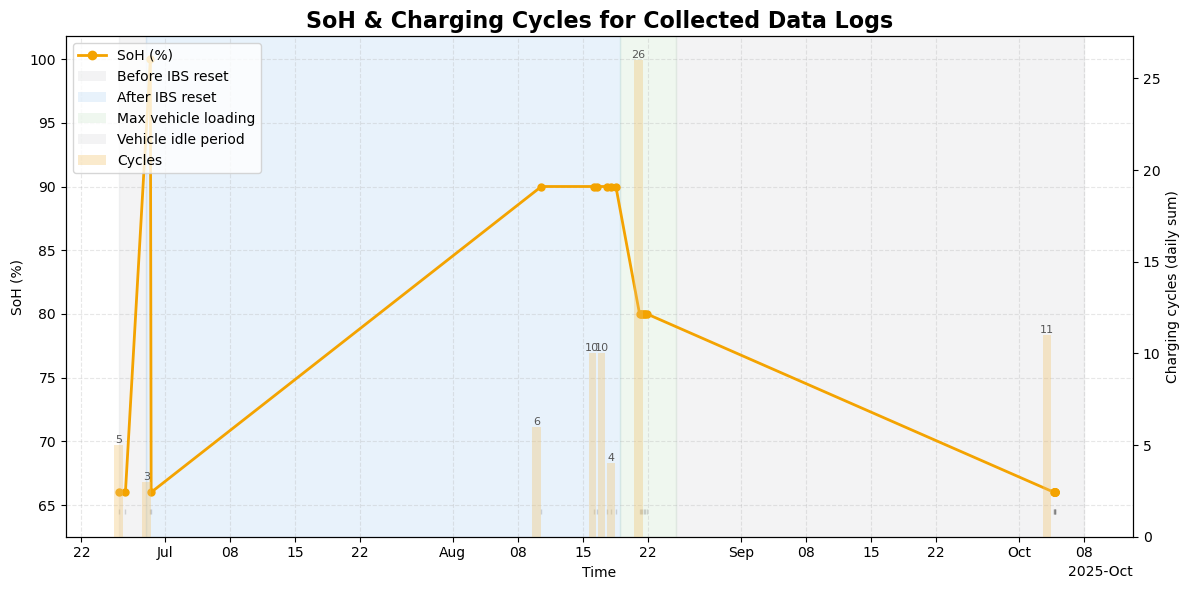

In [12]:
# Plot phases and overall clustered logs

phases = [
    {"label":"Before IBS reset",    "start": pd.Timestamp("2025-06-26"), "end": pd.Timestamp("2025-06-29")},
    {"label":"After IBS reset",     "start": pd.Timestamp("2025-06-29"), "end": pd.Timestamp("2025-08-19")},
    {"label":"Max vehicle loading", "start": pd.Timestamp("2025-08-19"), "end": pd.Timestamp("2025-08-25")},
    {"label":"Vehicle idle period", "start": pd.Timestamp("2025-08-25"), "end": pd.Timestamp("2025-10-08")},
]

# Choose whichever function name you have:
fig = plot_soh_cycles_with_colored_phases_clustered(
    df_logs,         # your manifest
    phases,          # your three phase dicts with start/end Timestamps
    time_col="time",
    soh_col="soh",
    cycles_col="cycles",
    soh_is_fraction=True,   # set False if 'soh' is already in %
    annotate_points=True,
    show_rug=True
)


## 3b. SOH and calculated Charging Cycles during specific time periods / events (Zoomed)

In [13]:
# Plot zoomed in data logs for specific dates

def plot_soh_cycles_window_raw(
    df: pd.DataFrame,
    phases: list,
    start: pd.Timestamp,
    end: pd.Timestamp,
    time_col="time",
    soh_col="soh",
    cycles_col="cycles",
    soh_is_fraction=True,
    title_prefix="SoH & Charging Cycles — window",
    annotate_bars=True,
    phase_colors=None,
    figsize=(12, 5),

    # --- match overall plot colors ---
    soh_color: str = "#f4a300",     # warm orange (SoH line/markers)
    cycles_color: str = "#f1c36d",  # soft amber (bars)
    phase_alpha: float = 0.25,      # same shading opacity
):
    """
    Zoomed window over [start, end]:
      • SoH line at event timestamps
      • Individual log bars (not aggregated), 'dodged' within each day
      • Colors match the overall plot
    """
    dfx = df.copy()
    dfx[time_col] = pd.to_datetime(dfx[time_col])
    mask = (dfx[time_col] >= pd.to_datetime(start)) & (dfx[time_col] <= pd.to_datetime(end))
    dfx = dfx.loc[mask].sort_values(time_col)
    if dfx.empty:
        raise ValueError("No logs in the requested window.")

    dfx["_soh_pct"] = dfx[soh_col] * 100.0 if soh_is_fraction else dfx[soh_col]

    # --- compute intraday dodging so per-log bars don't overlap ---
    dfx["day"] = dfx[time_col].dt.floor("D")
    dfx["rank_in_day"] = dfx.groupby("day")[time_col].rank(method="first")
    per_day_counts = dfx.groupby("day")["rank_in_day"].transform("max").clip(lower=1)
    # offsets centered around 0, scaled to ±0.3 day
    dfx["_offset_days"] = (dfx["rank_in_day"] - (per_day_counts + 1) / 2) / per_day_counts * 0.6
    x_positions = dfx[time_col] + pd.to_timedelta(dfx["_offset_days"], unit="D")
    bar_widths = 0.6 / per_day_counts  # each bar narrower when more logs that day

    fig, ax_soh = plt.subplots(figsize=figsize)

    # SoH line (match color)
    ax_soh.plot(
        dfx[time_col], dfx["_soh_pct"],
        marker="o", markersize=5, linewidth=2,
        color=soh_color, markerfacecolor=soh_color, markeredgecolor=soh_color,
        label="SoH (%)"
    )
    ax_soh.set_ylabel("SoH (%)")
    ax_soh.set_xlabel("Time")
    ax_soh.grid(True, linestyle="--", alpha=0.3)

    # Cycles bars (right axis), per log (match color/alpha)
    ax_cyc = ax_soh.twinx()
    ax_cyc.bar(
        x_positions, dfx[cycles_col], width=bar_widths, align="center",
        alpha=0.35, color=cycles_color, edgecolor="none", label="Charging cycles"
    )
    ax_cyc.set_ylabel("Charging cycles (per log)")

    if annotate_bars:
        for x, v in zip(x_positions, dfx[cycles_col]):
            if pd.notna(v) and v > 0:
                ax_cyc.text(x, v, f"{int(v)}", ha="center", va="bottom", fontsize=8, color="#555")

    # Colored phase shading (same palette & no text labels inside bands)
    if phase_colors is None:
        phase_colors = ["#d1d3d6", "#a4ccf1", "#c2e0c2"]  # same as overall
    for i, ph in enumerate(phases):
        s, e = ph["start"], ph["end"]
        if (e >= start) and (s <= end):  # overlap with window
            ax_soh.axvspan(max(s, start), min(e, end),
                           alpha=phase_alpha, color=phase_colors[i % len(phase_colors)])

    # X-axis formatting and limits (use same denser ticks)
    ax_soh.set_xlim(pd.to_datetime(start), pd.to_datetime(end))
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
    ax_soh.xaxis.set_major_locator(locator)
    ax_soh.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    # Legend
    ax_soh.legend([ax_soh.lines[0], ax_cyc.containers[0]],
                  ["SoH (%)", "Charging cycles (per log)"], loc="best")

    ax_soh.set_title(f"{title_prefix}: {pd.to_datetime(start).date()} → {pd.to_datetime(end).date()}")
    fig.tight_layout()
    return fig


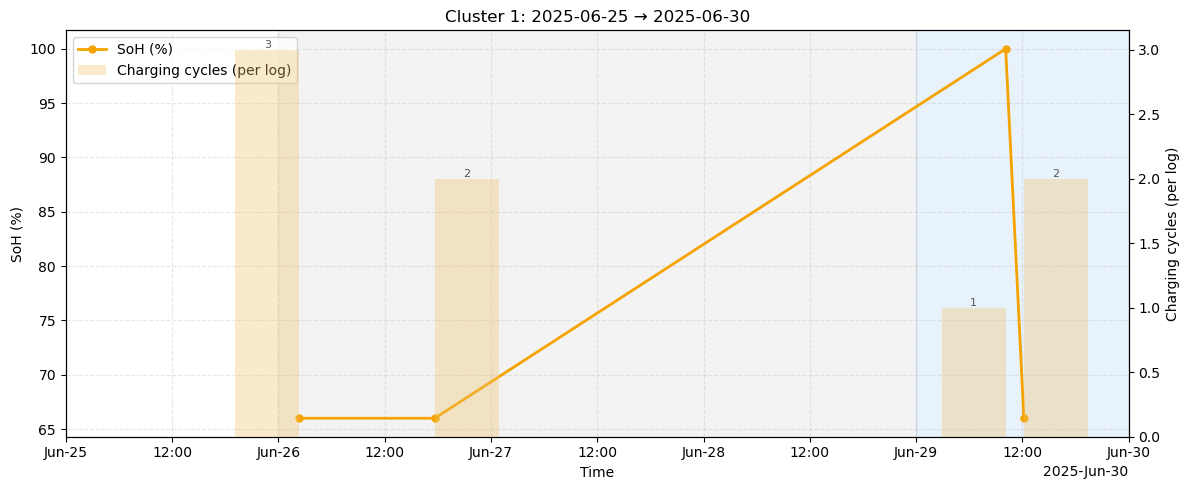

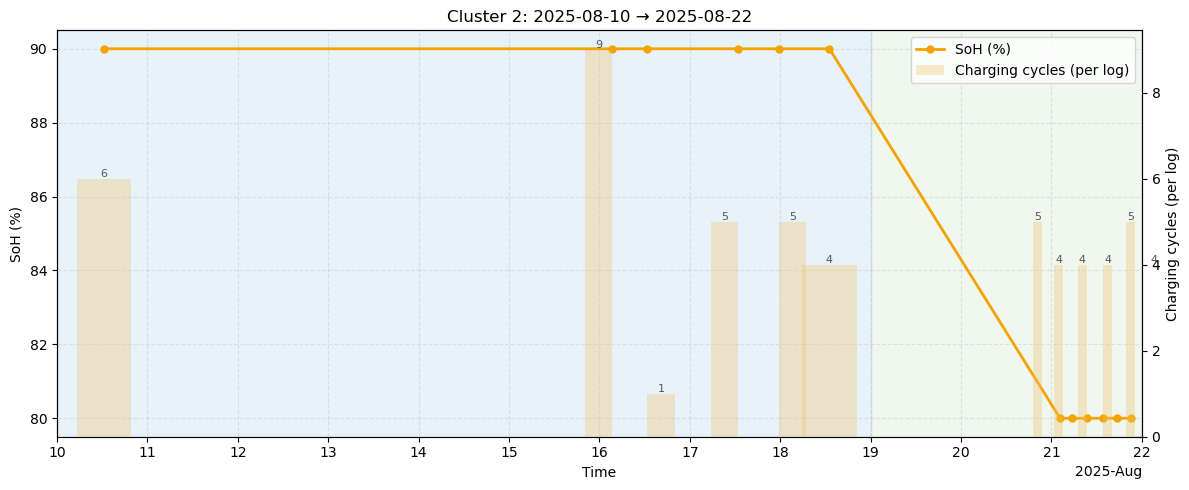

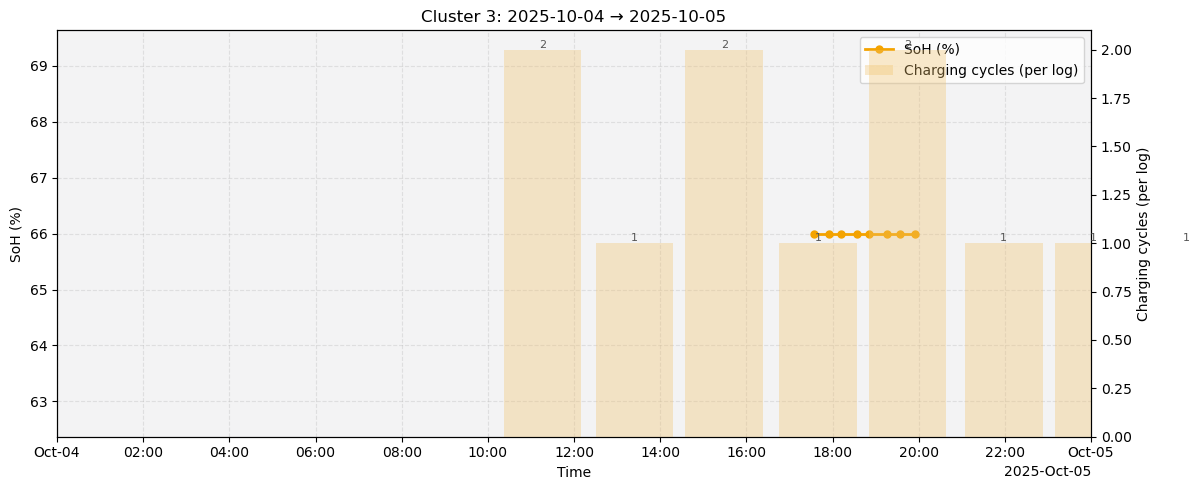

In [14]:
# Window 1: first cluster - Initial SoH reading through forced IBS reset
fig1 = plot_soh_cycles_window_raw(
    df_logs, phases,
    start=pd.Timestamp("2025-06-25"),
    end=pd.Timestamp("2025-06-30"),
    time_col="time", soh_col="soh", cycles_col="cycles",
    soh_is_fraction=True,
    title_prefix="Cluster 1"
)

# Window 2: second cluster - Maximum vehicle stressing of 12V battery
fig2 = plot_soh_cycles_window_raw(
    df_logs, phases,
    start=pd.Timestamp("2025-08-10"),
    end=pd.Timestamp("2025-08-22"),
    time_col="time", soh_col="soh", cycles_col="cycles",
    soh_is_fraction=True,
    title_prefix="Cluster 2"
)

# Window 3: third cluster - Final check of IBS SoH ~3 months after forced reset
fig3 = plot_soh_cycles_window_raw(
    df_logs, phases,
    start=pd.Timestamp("2025-10-04"),
    end=pd.Timestamp("2025-10-05"),
    time_col="time", soh_col="soh", cycles_col="cycles",
    soh_is_fraction=True,
    title_prefix="Cluster 3"
)


## 4. Plot of IBS SOH vs Calculated SOH₁ based on traditional algorithm approach*
### *Should approximate the reported vender IBS sensor SoH 
---

## Calculated SOH₁ (12-V Battery)

**What it is:**
A single daily score (0–1) for 12-V battery health that blends **capacity** (how many Ah remain) and **resistance** (how much internal resistance has grown).

### Inputs

* Time series: **Voltage V(t)**, **Current I(t)**, **Temperature T(t)** (IBS/telemetry).
* Optional: OEM/IBS metrics (used only as fallback).

### Quick filters

* Resample to a steady cadence (e.g., **2 s**).
* Keep **warm** data only (e.g., **T ≥ 15 °C**).
* Detect charge/discharge **windows**; merge tiny gaps.

### Two simple estimates

* **Capacity (Ĉ):** integrate current over windows with enough depth-of-discharge (e.g., **≥10% DoD**). Use the **median** of valid windows per day.
* **Resistance (R̂):** find small current steps (e.g., **≥5 A**); estimate **ΔV/ΔI** and take the **median** per day.

### Normalize vs. early “healthy” reference

* Set **C₀** and **R₀** from the first **~14 days** of good (warm) data.
* Capacity health: **SOH_C = clip(Ĉ / C₀, 0–1)**
* Resistance health: **SOH_R = clip(R₀ / R̂, 0–1)**

### Combine

* **SOH₁ = α·SOH_C + (1−α)·SOH_R**, with **α ≈ 0.7** (capacity-weighted).
* Optionally smooth with a light 7-day EMA.

### Fallbacks

* If a day has no valid windows/steps: carry forward last valid **SOH₁**; if none, leave **NaN** (or cautiously use an IBS proxy).

### Typical defaults

* `RESAMPLE_SECONDS=2`, `EARLY_DAYS=14`, `MIN_WARM_TEMP=15`, `DOD_MIN_PERCENT=10`, `STEP_MIN_DI=5`, `alpha=0.7`.

### Outputs

* Daily table: **date, SOH₁, SOH_C, SOH_R, Ĉ, R̂, counters**.
* Plot: smoothed **SOH₁** over time.

**Notes:** simple temperature handling (warm-only), assumes reasonable current calibration, and prefers interpretability over heavy modeling.


In [15]:
# Define function for plotting IBS SOH vs calculated SOH1 comparison 

def plot_soh_comparison_with_phases(
    df: pd.DataFrame,
    phases: list,
    time_col: str = "time",
    ibs_soh_col: str = "soh",     # IBS vendor SoH
    soh1_col: str = "soh1",       # your calculated SoH1
    title: str = "Comparison of IBS SoH vs. Calculated SoH1 for all Collected Data Logs",
    soh_is_fraction: bool = True, # False if already percent 0–100
    figsize=(12, 6),
    # colors to match your overall style
    ibs_color: str = "#f4a300",   # IBS SoH (orange)
    soh1_color: str = "#3b6fb6",  # SOH1 (blue)
    phase_colors: list | None = None,
    phase_alpha: float = 0.25,
    annotate_metrics: bool = True,   # show R² & RMSE box in the plot
):
    if phase_colors is None:
        phase_colors = ["#d1d3d6", "#a4ccf1", "#c2e0c2"]

    dfx = df.copy()
    dfx[time_col] = pd.to_datetime(dfx[time_col])
    dfx = dfx.sort_values(time_col)

    # to percent if needed
    def to_pct(s):
        s = pd.to_numeric(s, errors="coerce")
        return (s * 100.0) if soh_is_fraction else s

    y_ibs  = to_pct(dfx[ibs_soh_col])
    y_soh1 = to_pct(dfx[soh1_col])

    # compute metrics
    mask = y_ibs.notna() & y_soh1.notna()
    r2   = r2_score(y_ibs[mask], y_soh1[mask]) if mask.any() else np.nan
    rmse = np.sqrt(mean_squared_error(y_ibs[mask], y_soh1[mask])) if mask.any() else np.nan

    fig, ax = plt.subplots(figsize=figsize)

    # lines
    ibs_line,  = ax.plot(dfx[time_col], y_ibs,  marker="o", markersize=5, linewidth=2,
                         color=ibs_color,  markerfacecolor=ibs_color,  markeredgecolor=ibs_color,
                         label="IBS SoH")
    soh1_line, = ax.plot(dfx[time_col], y_soh1, marker="o", markersize=5, linewidth=2,
                         color=soh1_color, markerfacecolor=soh1_color, markeredgecolor=soh1_color,
                         label="Calculated SoH1")

    # axes/grid
    ax.set_ylabel("SoH (%)")
    ax.set_xlabel("Time")
    ax.grid(True, linestyle="--", alpha=0.3)

    # phase shading (no text labels inside)
    phase_patches = []
    for i, ph in enumerate(phases):
        start, end = ph["start"], ph["end"]
        col = phase_colors[i % len(phase_colors)]
        ax.axvspan(start, end, alpha=phase_alpha, color=col)
        phase_patches.append(Patch(facecolor=col, edgecolor="none", alpha=phase_alpha, label=ph.get("label", f"Phase {i+1}")))

    # x-axis formatting (denser ticks)
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    # legend
    legend_items = [
        Line2D([0], [0], color=ibs_color,  marker="o", linewidth=2, label="IBS SoH"),
        Line2D([0], [0], color=soh1_color, marker="o", linewidth=2, label="Calculated SoH1"),
    ] + phase_patches
    ax.legend(legend_items, [h.get_label() for h in legend_items], loc="upper left")

    # inline metrics box (top-right)
    if annotate_metrics and not np.isnan(r2) and not np.isnan(rmse):
        text = f"R² = {r2:.3f}\nRMSE = {rmse:.3f}"
        ax.text(0.98, 0.02, text,
                transform=ax.transAxes, ha="right", va="bottom",
                fontsize=10,
                bbox=dict(facecolor="white", edgecolor="#999", alpha=0.9, boxstyle="round,pad=0.4"))

    ax.set_title(title, fontsize=16, weight="bold")
    fig.tight_layout()
    return fig, {"r2": r2, "rmse": rmse}


{'r2': -0.9719282799124509, 'rmse': 15.510046943930593}


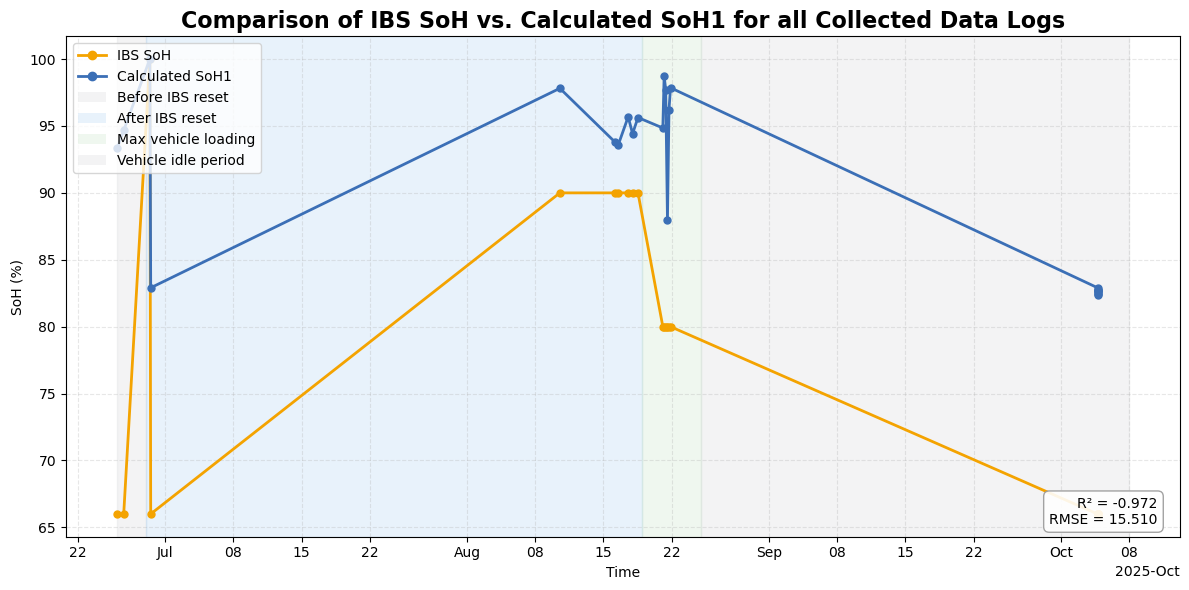

In [16]:
fig_comp, metrics = plot_soh_comparison_with_phases(
    df_logs,
    phases=phases,
    time_col="time",
    ibs_soh_col="soh",
    soh1_col="soh1",
    soh_is_fraction=True  # False if your columns already in %
)
print(metrics)
